In [171]:
%matplotlib inline
%load_ext autoreload
%autoreload

from quanty.model import backtester as q
from quanty.model import backtester_base as q_base
from quanty.model import db_manager as dm
from quanty.model import plotter as pltr
from quanty.model import setting
from quanty.model.portfolio import Port
from quanty.model.dual_momentum import DualMomentumSelector, DualMomentumPort

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
db = dm.read_db(base='prices_global.pkl', add=['prices_global_gwx.pkl'])
db_kr = dm.read_db(base='prices_kr.pkl', add=['prices_global.pkl'])

In [221]:
mix = q_base.BacktestComparator(setting.base_params(db), multiasset=multiasset, geam=geam, kfam=kfam, gsam=gsam, gfam=gfam)
mix.mix()

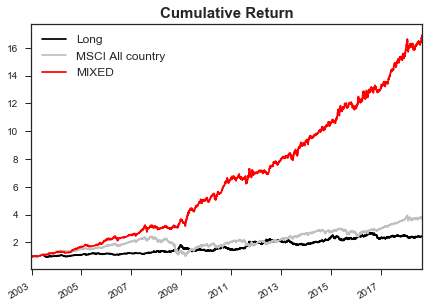

In [222]:
strats = ['BND_US_Long', 'ACWI', 'mixed']
names = ['Long', 'MSCI All country', 'MIXED']
color = ['k', 'silver', 'r']

mix.plot_cum(strats, names=names, color=color, logy=False)

In [168]:
mix.stats.tail(6)

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
multiasset,13.29,3946,17.82,13.86,1.29,-16.29,16.77,12.65,1.16,0.18,5.22,63.64,1.60,86.66
geam,8.53,3946,14.55,15.77,0.92,-23.46,14.22,15.74,0.91,0.23,12.96,61.50,1.30,90.01
kfam,33.37,3946,24.89,13.22,1.88,-18.30,24.29,12.20,2.16,0.09,8.14,71.66,1.50,94.06
gsam,7.90,3946,13.99,15.13,0.92,-20.69,13.94,13.65,0.98,0.35,9.44,62.03,1.31,97.78
gfam,3.15,3946,7.55,6.16,1.23,-12.06,5.97,5.36,1.22,0.02,2.89,66.84,1.29,97.19
mixed,16.92,3946,19.63,10.23,1.92,-15.42,17.48,9.38,2.07,0.19,1.65,71.12,1.62,96.72


In [217]:
mix.stats.tail(6)

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
multiasset,13.29,3946,17.82,13.86,1.29,-16.29,16.77,12.65,1.16,0.18,5.22,63.64,1.60,86.66
geam,8.53,3946,14.55,15.77,0.92,-23.46,14.22,15.74,0.91,0.23,12.96,61.50,1.30,90.01
kfam,34.59,3946,25.18,13.85,1.82,-19.46,24.12,12.69,2.15,0.09,7.01,71.66,1.37,93.43
gsam,7.90,3946,13.99,15.13,0.92,-20.69,13.94,13.65,0.98,0.35,9.44,62.03,1.31,97.78
gfam,3.15,3946,7.55,6.14,1.23,-12.06,5.97,5.36,1.22,0.02,2.89,66.84,1.29,97.19
mixed,13.91,3946,18.16,10.16,1.79,-16.31,17.31,9.37,1.90,0.18,1.35,70.05,1.52,96.49


In [169]:
rt = mix.cum.mixed.resample('M').ffill().pct_change()#.plot.bar()
rt[rt<-0.05]

2009-01-31   -0.070334
2010-05-31   -0.052641
Name: mixed, dtype: float64

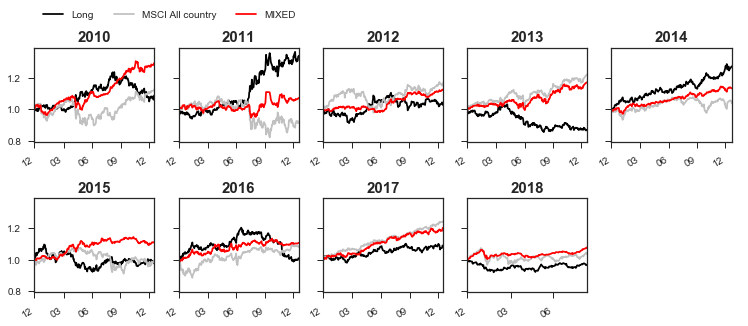

In [170]:
mix.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2010))

# Multiasset model

In [172]:
multiasset = q.Backtester(
    setting.base_params(db), 
    w_type='inv_ranky2', 
    n_picks=5, 
    assets=setting.assets_multiasset, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,1,2,3], 
    sig_w_dynamic=True, #False, 
    sig_dyn_fwd=21*np.array([1,2,3]), 
    #sig_dyn_m_backs=24, 
    follow_trend=None, #(20,60), 
    follow_trend_market=None, #(20,60), 
    follow_trend_supporter=(20,60), 
    strong_condition=True, 
    market='ACWI', 
    supporter='BND_US_Long', 
    cash_equiv='BND_US_Short', 
    start='2002-12-31', 
    losscut=0.05, 
    profitake_sigma=3, 
)


11.091599941253662


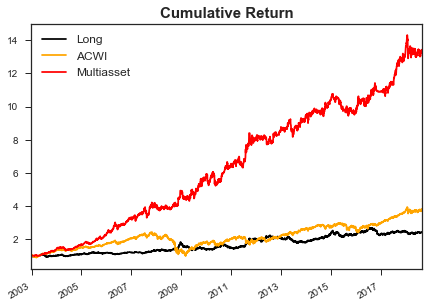

In [173]:
strats = ['BND_US_Long', 'ACWI', 'DualMomentum']
names = ['Long', 'ACWI', 'Multiasset']
color = ['k', 'orange', 'r']

multiasset.plot_cum(strats, names=names, color=color, logy=False)

In [174]:
rt = multiasset.cum.DualMomentum.resample('M').ffill().pct_change()
rt[rt<-0.05]

2004-04-30   -0.066727
2005-10-31   -0.054951
2007-08-31   -0.061231
2009-01-31   -0.092338
2009-04-30   -0.055583
2010-01-31   -0.061118
2010-05-31   -0.076441
2013-05-31   -0.057922
2018-02-28   -0.060090
Name: DualMomentum, dtype: float64

In [175]:
multiasset.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
PrecMetal,2.98,3945,7.17,20.88,0.34,-55.70,7.23,19.33,0.41,0.16,36.28,54.84,1.14,40.68
USD_DOWN,0.87,2938,-1.14,8.43,-0.14,-31.61,-0.92,8.30,-0.12,0.15,56.27,52.90,0.85,1.21
US_Total,4.87,3946,10.55,18.08,0.58,-55.45,13.97,12.83,1.08,0.90,15.69,68.98,0.85,83.00
Developed,3.07,3946,7.38,21.57,0.34,-61.04,13.38,15.66,0.88,1.10,29.27,60.43,0.98,16.82
DualMomentum,13.29,3946,17.82,13.86,1.29,-16.29,16.77,12.65,1.16,0.18,5.22,63.64,1.60,86.66


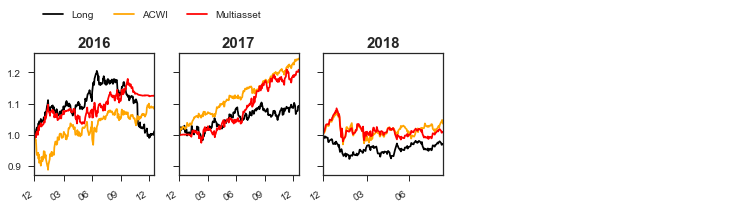

In [176]:
multiasset.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2016))

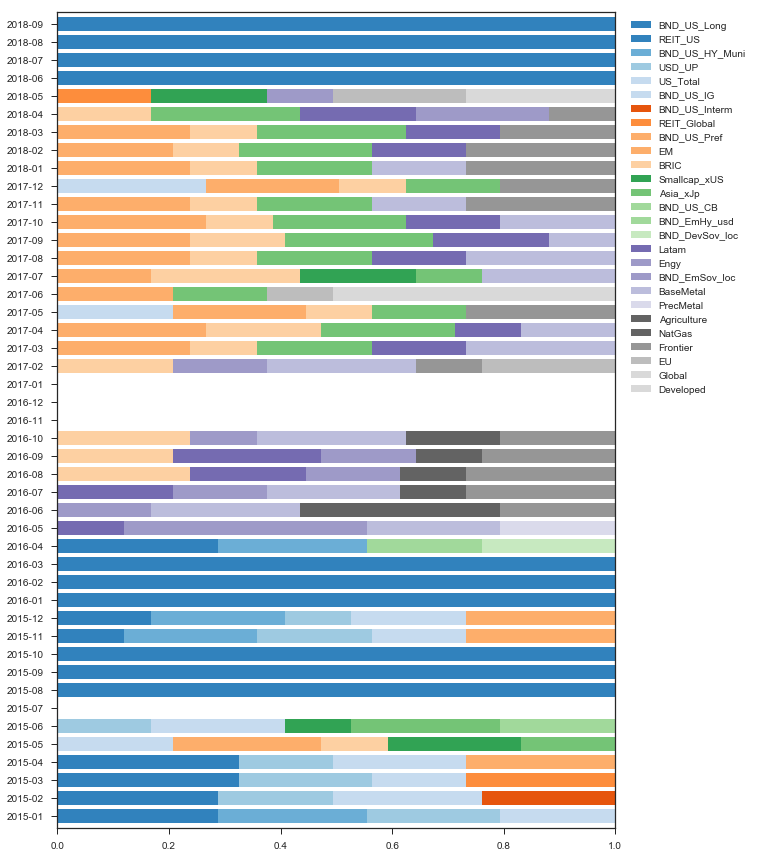

In [177]:
multiasset.plot_weight([2015, 2018])

# Global equity allocation model

In [178]:
geam = q.Backtester(
    setting.base_params(db), 
    w_type='inv_ranky2', 
    n_picks=5, 
    assets=setting.assets_global_eq, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,0,0,0], 
    sig_w_dynamic=True, #False, 
    sig_dyn_fwd=21*np.array([1]), 
    #sig_dyn_m_backs=24, 
    follow_trend=(20,60), 
    follow_trend_market=(20,60), 
    follow_trend_supporter=(20,60), 
    strong_condition=True, 
    market='ACWI', 
    supporter='BND_US_Long', 
    cash_equiv='BND_US_Short', 
    start='2002-12-31', 
    losscut=0.05, 
    profitake_sigma=3, 
)


12.635999917984009


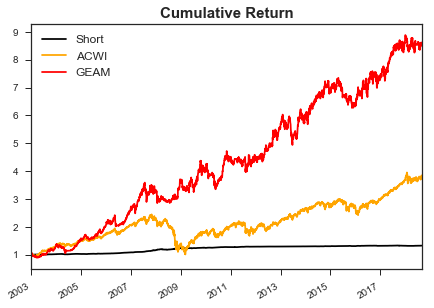

In [179]:
strats = ['BND_US_Short', 'ACWI', 'DualMomentum']
names = ['Short', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

In [180]:
geam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Indonesia,8.79,3946,14.77,29.99,0.49,-72.14,17.52,28.43,0.68,0.67,28.00,61.50,1.05,37.32
Colombia,1.54,2409,4.61,22.57,0.20,-68.71,5.18,22.37,0.25,0.71,41.44,56.64,1.01,-185.33
Poland,1.02,2126,0.22,28.24,0.01,-52.81,2.84,24.28,0.12,1.35,47.10,48.00,1.22,3.55
Spain,3.06,3946,7.34,28.00,0.26,-61.19,12.24,22.99,0.54,1.25,38.08,57.75,1.02,-95.50
DualMomentum,8.53,3946,14.55,15.77,0.92,-23.46,14.22,15.74,0.91,0.23,12.96,61.50,1.30,90.01


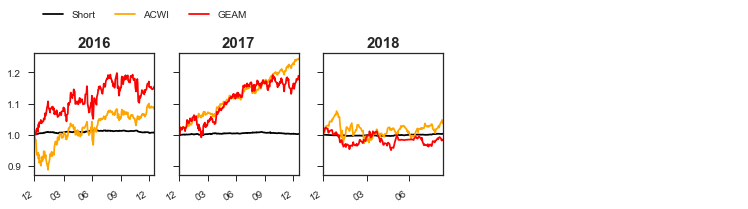

In [181]:
geam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2016))

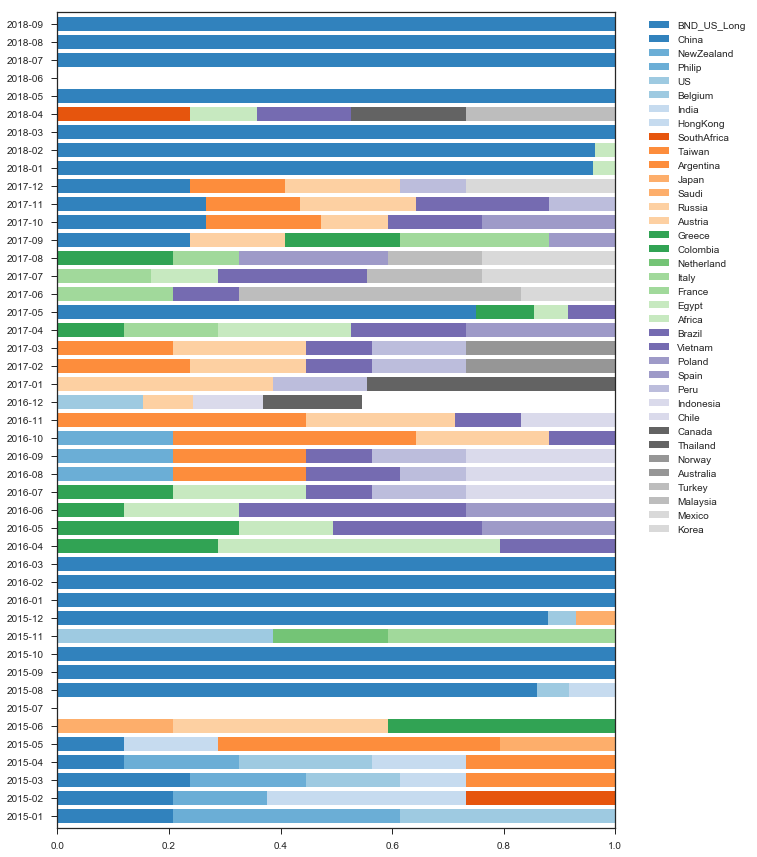

In [182]:
geam.plot_weight([2015, 2018])

# Global sector allocation model

In [183]:
gsam = q.Backtester(
    setting.base_params(db), 
    w_type='inv_ranky2', 
    n_picks=10, 
    assets=setting.assets_global_sector, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,0,0,0], 
    sig_w_dynamic=True, #False, 
    sig_dyn_fwd=21*np.array([1]), 
    #sig_dyn_m_backs=24, 
    follow_trend=(20,60), 
    follow_trend_market=(20,60), 
    follow_trend_supporter=(20,60), 
    strong_condition=True, 
    market='ACWI', 
    supporter='BND_US_Long', 
    cash_equiv='BND_US_AGG', 
    start='2002-12-31', 
    losscut=0.05,
    profitake_sigma=3, 
)


13.447199821472168


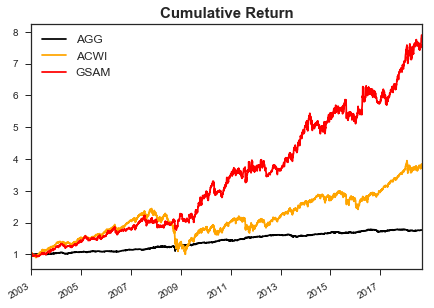

In [184]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GSAM']
color = ['k', 'orange', 'r']

gsam.plot_cum(strats, names=names, color=color, logy=False)

In [185]:
gsam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
ConsumerGoods,4.02,3946,9.21,14.45,0.64,-42.64,11.48,11.49,0.99,0.64,13.01,63.10,1.12,91.95
Solar,0.60,3381,-3.73,45.23,-0.08,-96.10,-1.93,40.03,-0.05,1.58,51.88,51.88,1.06,-2.23
Semiconductor,6.23,3946,12.30,27.46,0.45,-66.85,13.75,23.50,0.56,1.07,32.49,57.75,1.15,56.09
OnlineRetail,4.70,1953,21.92,16.46,1.33,-22.40,19.32,14.90,1.32,0.83,6.75,72.83,1.27,94.18
DualMomentum,7.90,3946,13.99,15.13,0.92,-20.69,13.94,13.65,0.98,0.35,9.44,62.03,1.31,97.78


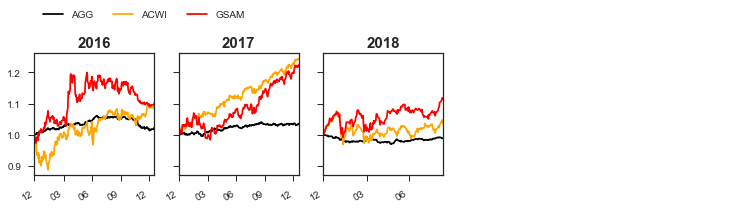

In [186]:
gsam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2016))

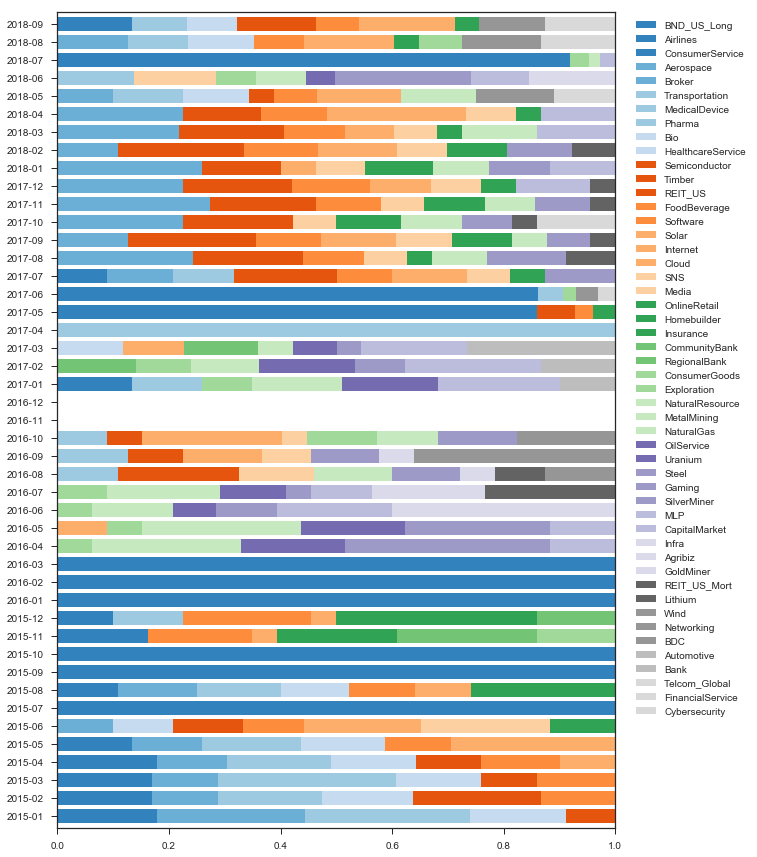

In [187]:
gsam.plot_weight([2015, 2018])

# Global fixed-income allocation model

In [188]:
gfam = q.Backtester(
    setting.base_params(db), 
    w_type='ranky2', 
    freq='1M', 
    n_picks=5, 
    assets=setting.assets_fi, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,1,2,3], 
    sig_w_dynamic=False, 
    #sig_dyn_fwd=21*np.array([1,2,3]), 
    #sig_dyn_m_backs=12, 
    follow_trend=(20,60), 
    follow_trend_market=(20,60), 
    follow_trend_supporter=(60,250), 
    strong_condition=True, 
    market='BND_US_AGG', #'BND_GlobalSov_loch', #'BND_US_AGG', 
    supporter='BND_US_Long', 
    cash_equiv='BND_US_Short', 
    start='2002-12-31', 
    losscut=0.05, 
    profitake_sigma=10, 
)


9.391199827194214


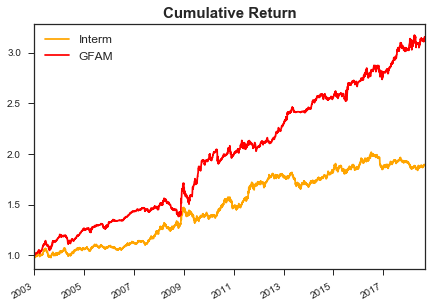

In [189]:
strats = ['BND_US_Interm', 'DualMomentum']
names = ['Interm', 'GFAM']
color = ['orange', 'r']

gfam.plot_cum(strats, names=names, color=color, logy=False)

In [156]:
gfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
BND_DevSov_loc,1.83,3946,3.91,8.91,0.44,-15.77,3.48,8.67,0.41,0.07,31.89,57.75,1.07,45.35
BND_US_Muni,1.51,2771,3.80,5.31,0.72,-12.33,3.48,3.94,0.83,0.00,18.99,64.12,1.04,93.08
BND_EmSov_usd,3.19,3946,7.63,9.35,0.82,-34.70,8.23,6.69,1.41,0.14,17.72,68.98,0.90,87.03
BND_US_Interm,1.89,3946,4.12,6.58,0.63,-10.40,4.68,6.07,0.73,-0.13,23.80,55.61,1.37,93.93
DualMomentum,3.15,3946,7.55,6.16,1.23,-12.06,5.97,5.36,1.22,0.02,2.89,66.84,1.29,97.19


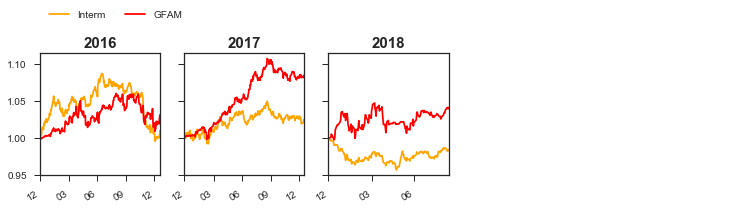

In [191]:
gfam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2016))

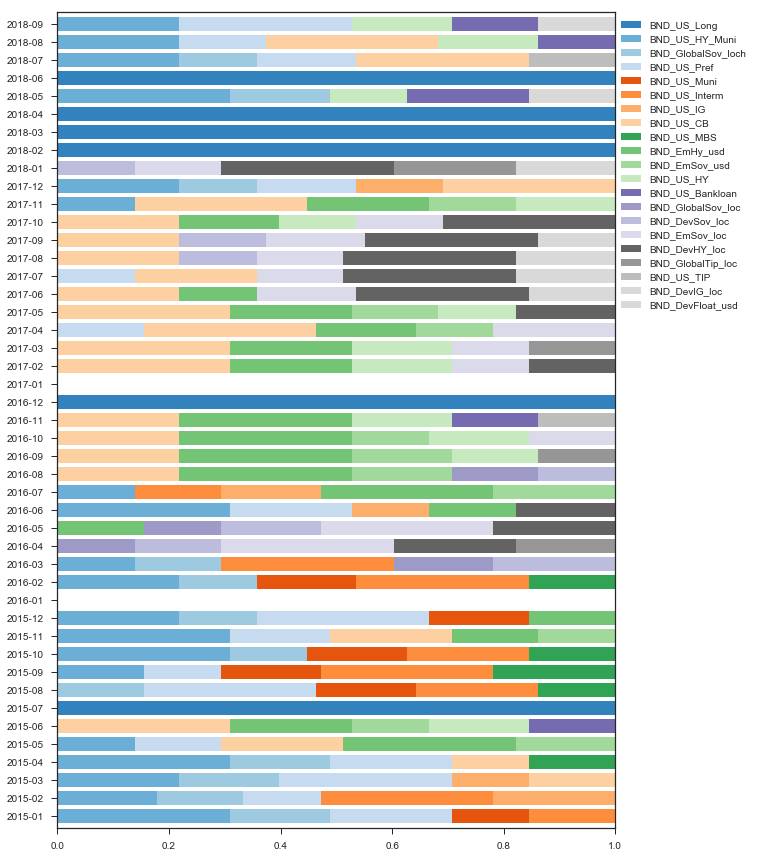

In [192]:
gfam.plot_weight([2015, 2018])

In [136]:
%matplotlib inline
%load_ext autoreload
%autoreload

from quanty.model import backtester as q
from quanty.model import db_manager as dm
from quanty.model import plotter as pltr
from quanty.model import setting
from quanty.model.portfolio import Port
from quanty.model.dual_momentum import DualMomentumSelector, DualMomentumPort

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Korea factor allocation model

In [218]:
kfam = q.Backtester(
    setting.base_params(db_kr), 
    w_type='inv_ranky2', # ranky2 가 더 잘나오긴 한다. ----
    freq='1M', 
    n_picks=5, 
    assets=setting.assets_kr_factor, #|setting.assets_us_factor2, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,1,2,3], 
    sig_w_dynamic=True, 
    sig_dyn_fwd=21*np.array([1,2,3]), 
    #sig_dyn_m_backs=12, 
    follow_trend=None, #(20,60), 
    follow_trend_market=(20,60), 
    follow_trend_supporter=(60,250), 
    strong_condition=True, 
    market='K200', 
    supporter='KTB10YL', 
    cash_equiv= 'KTB10Y', 
    #trade_assets=[('K200', {'K200L':0.5})], 
    start='2002-12-31', 
    losscut=0.03, 
    profitake_sigma=10, 
)


9.203999996185303


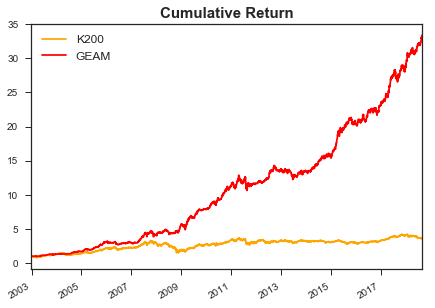

In [219]:
strats = ['K200', 'DualMomentum']
names = ['K200', 'GEAM']
color = ['orange', 'r']

kfam.plot_cum(strats, names=names, color=color, logy=False)

In [220]:
kfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
KTB10Y,2.05,4064,4.53,5.33,0.85,-9.78,5.00,4.77,0.85,-0.01,23.49,67.38,0.95,94.24
Momentum_kr,3.72,1728,20.95,19.19,1.09,-35.89,25.25,18.24,1.31,0.20,25.35,67.95,1.16,79.19
ESG_kr,1.30,1512,4.40,10.82,0.41,-16.82,6.09,10.02,0.61,0.19,36.03,57.97,1.09,47.96
Value_kr,7.35,4064,13.06,20.90,0.62,-57.56,9.74,18.44,0.61,0.33,23.22,58.82,1.22,39.89
DualMomentum,33.39,4064,24.09,13.02,1.85,-18.30,23.50,12.06,2.17,0.09,8.96,71.66,1.53,94.08


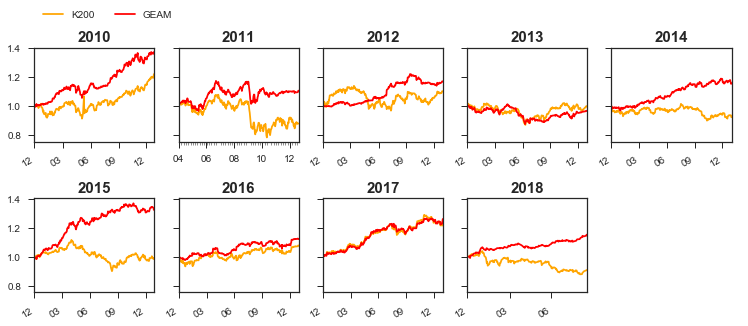

In [213]:
kfam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2010))

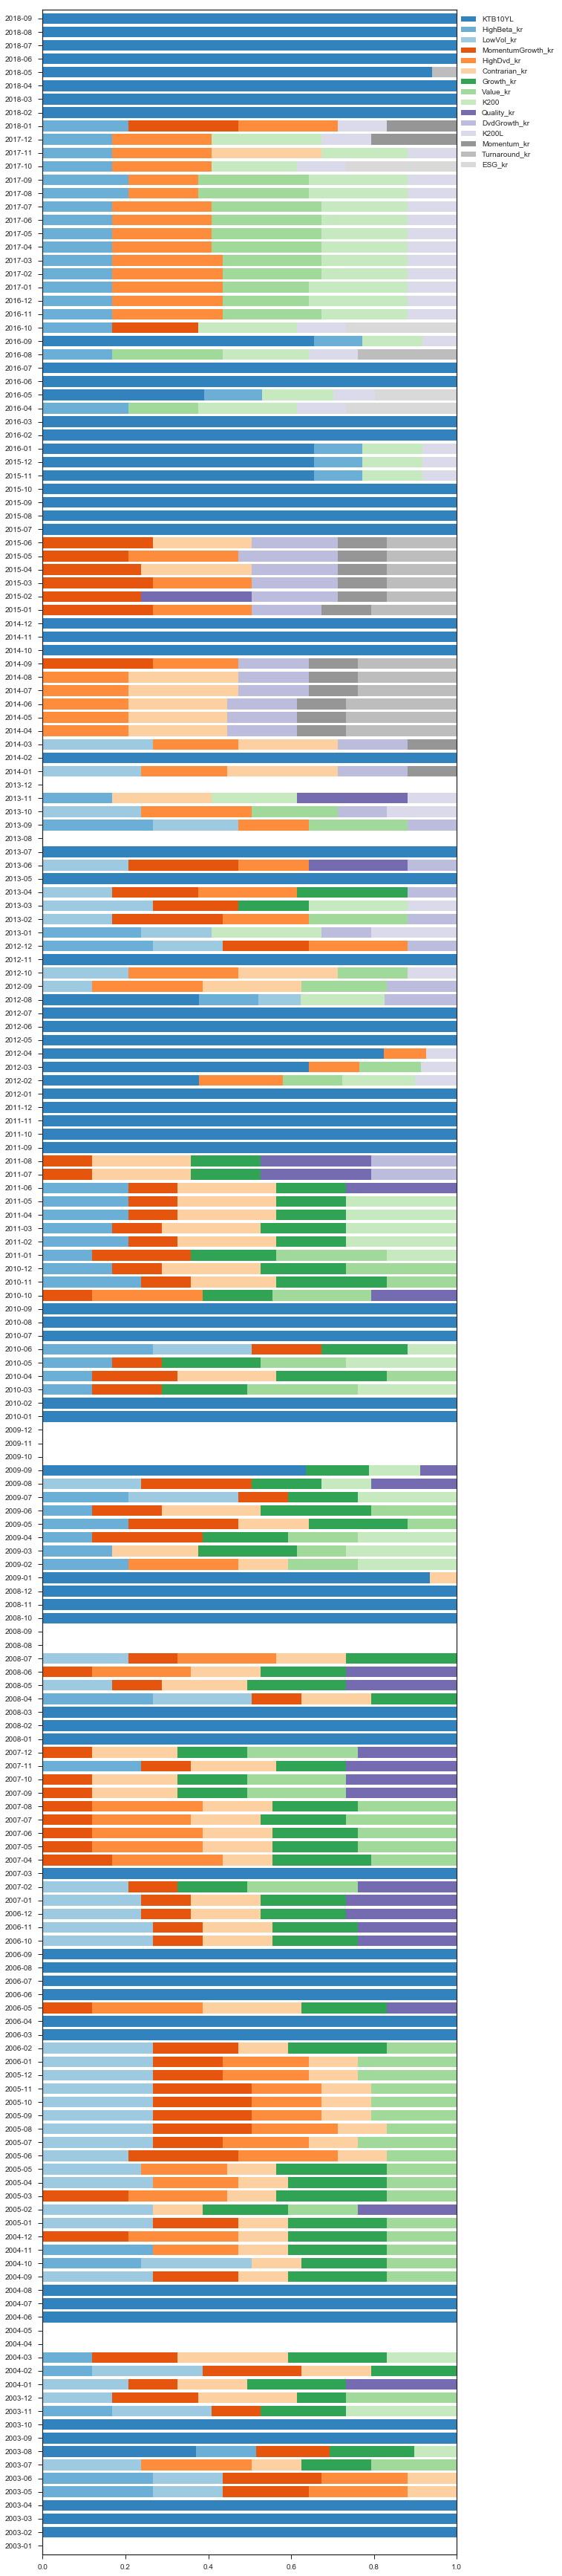

In [214]:
kfam.plot_weight([2003, 2018])